# Requirements
pdfminer.six

chardet==3.0.4

tesseract-ocr

imagemagick

poppler-utils






In [1]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from pytesseract import Output
from utils import convert_key_value_pairs
pytesseract.pytesseract.tesseract_cmd = r'E:\Downloads\Tesseract OCR\tesseract.exe'

Loading from E:\Nitin\RVCE\Projects\PDF-OCR\code\models
Entities []


# Helper functions

In [4]:
def sharpen_image(img):
    # Input:
        # img - image for sharpening
    #kernel for sharpening image
    kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1],
                       [-1,-1,-1]])

    #Sharpen the image for better text recognition
    sharpened = cv2.filter2D(img, -1, kernel)
    return sharpened

def plot_image(img):
    # @input:
        #img - sharpened image
    #Extract text from image
    text = pytesseract.image_to_string(img)
    plt.imshow(img)
    #Set title of the image as the extracted text
    plt.title(text)
    plt.show()

def get_coordinates_from_xlsx(path):
    # @input
    #  - path = The path to the excel file (template)

    # @ Output
    #   Dictionary containing co-ordinates of the form
    #   {
    #           "Label Name":
    #           {
    #             "top_left":(x1,y1),
    #             "bottom_right":(x2,y2)
    #           }
    #   }

    import pandas as pd
    #df = pd.read_excel('./Sample images/Data-1132.xlsx')
    df = pd.read_excel(path)
    
    #Extract width height and top left x,y co-ordinates
    w     = df.iloc[:,0]
    h     = df.iloc[:,1]
    x1    = df.iloc[:,2]
    y1    = df.iloc[:,3]
    #Extract labels as a list
    label = list(df.iloc[:,4])

    # Add width and height to x1 and y1 respectively to get the bottom right co-ordinates
    x2 = x1+w
    y2 = y1+h

    coordinates = {}
    for i in range(len(label)):    
        coordinates[label[i]] = {"top_left":(x1[i],y1[i]),"bottom_right":(x2[i],y2[i])}
    coordinates

    return coordinates

def predict_image(path,excel_path):
    # @Input
    #   path = The path to the image associated to the template file (Excel)

    # @Output
    #   Image marked with the rectangles around entities and outputs of each entity

    import cv2 as cv
    import numpy as np
    from matplotlib import pyplot as plt

    img = cv.imread(path,0)
    plt.imshow(img)
    plt.show()
    coordinates = get_coordinates_from_xlsx(excel_path)

    for k in coordinates.keys():
        x1,y1 = coordinates[k].get('top_left')
        x2,y2 = coordinates[k].get('bottom_right')
        # cv.rectangle(
        #             img,
        #             (x1,y1),
        #             (x2,y2),
        #             (0,0,255),
        #             1
        #     )
        
        sub_image = img[y1:y2+2,x1-2:x2+5]        
        # Sharpen the image for better text recognition
        sharpened = sharpen_image(sub_image)
        print(k)
        plot_image(sharpened)
    
    

# Template test

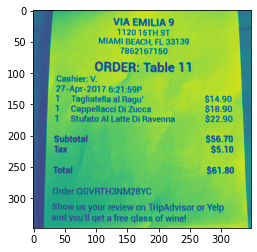

Company Name


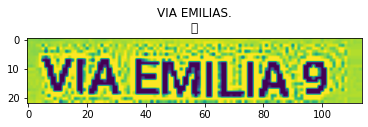

Company Address


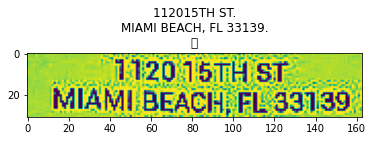

Invoice Number


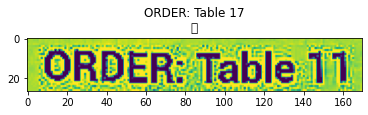

Tax


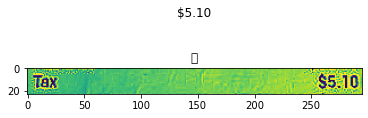

Total


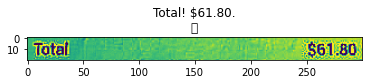

In [5]:
predict_image(
    './Sample images/1132-receipt.jpg',
    './Sample images/Data-1132.xlsx'
    )

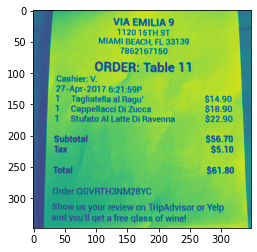

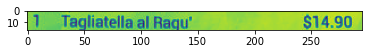

In [4]:
(x1,y1) = (31,132)
(x2,y2) = (326,149)
img1 = cv2.imread('./Sample images/1132-receipt.jpg',0)
img2 = img1[y1:y2,x1:x2]

# Initiate SIFT detector
#plot_image(img1)
#plot_image(img2)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()



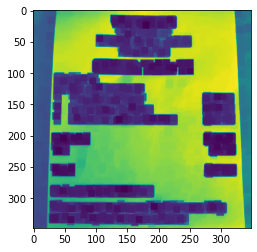

In [16]:
import numpy as np
kernel = np.ones((11,11))

img3 = img1.copy()
img3 = cv2.erode(img3,kernel)


#img3 = cv2.dilate(img3,kernel)

plt.imshow(img3)

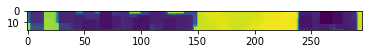

In [17]:
img4 = img2.copy()
kernel = np.ones((11,11))
img4 = cv2.erode(img4,kernel)

plt.imshow(img4)

4704.0


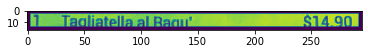

In [14]:
contours, hierarchy = cv2.findContours(img4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img6 = img2.copy()
cv2.drawContours(img6, contours, -1, (0,255,0), 3)
plt.imshow(img6)
print(cv2.contourArea(contours[0]))

In [ ]:
import imutils
img6 = img1.copy()
_,thresh = cv2.threshold(img6,127,255,cv2.THRESH_BINARY)
kernel = np.ones((7,7))
thresh = cv2.erode(thresh,kernel)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#contours = imutils.grab_contours(contours)
#contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

threshold = 4704
for cnt in contours:
    if cv2.contourArea(cnt)>threshold:
        print(cnt[0],cnt[1])
        print("\n\n")
        cv2.rectangle(img6, cnt, -1, (0,255,0), 3)
plt.imshow(img6)
plt.show()
plt.imshow(thresh)
plt.show()

3


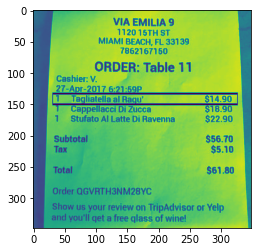

In [9]:
# Store width and height of template in w and h 
w, h = img4.shape[::-1] 
  
# Perform match operations. 
res = cv2.matchTemplate(img3,img4,cv2.TM_CCOEFF_NORMED) 
  
# Specify a threshold 
threshold = 0.95
  
# Store the coordinates of matched area in a numpy array 
loc = np.where( res >= threshold)  
img5 = img1.copy()  
# Draw a rectangle around the matched region.
count = 0
for pt in zip(*loc[::-1]): 
    cv2.rectangle(img5, pt, (pt[0] + w, pt[1] + h), (0,255,255), 1) 
    count+=1
print(count)
# Show the final image with the matched area. 
plt.imshow(img5)

# Excel annotation

In [13]:
import pandas as pd
import json,math
path = './Sample images/Data.csv'
df = pd.read_csv(path,sep=',',header=None)

annotate_dict = {}
number_of_rows = df.shape[0]
for r in range(0,number_of_rows):
    row1 = df.iloc[r,:]
    annotate_dict['page '+str(r+1)] = []
    for i in range(1,len(row1)):
        if str(row1[i])!='nan':
            temp_dict = eval(str(row1[i]))
            label = temp_dict['label']
            x1 = temp_dict['left']
            y1 = temp_dict['top']
            h = temp_dict['height']
            w = temp_dict['width']
            x2 = x1+w
            y2 = y1+h
            annotate_dict['page '+str(r+1)].append(
                {
                    label:(x1,y1,x2,y2)
                }
            )
annotate_dict

{'page 1': [{'Company Name': (3171, 2945, 4385, 3287)},
  {'Company Address': (2528, 3302, 5085, 3744)},
  {'Invoice Number': (1714, 4659, 3199, 4901)},
  {'Tax': (1528, 6617, 6085, 6974)},
  {'Total': (1485, 7140, 6185, 7811)}],
 'page 2': [{'Invoice Number': (400, 3259, 2271, 3530)},
  {'Company Name': (2114, 1028, 4342, 1285)},
  {'Company Address': (1642, 1271, 4927, 1828)},
  {'Tax': (285, 7748, 6527, 8033)},
  {'Total': (314, 8048, 6628, 8490)}],
 'page 3': [{'Company Name': (2957, 1142, 3885, 1399)},
  {'Company Address': (2342, 1439, 4542, 1896)},
  {'Invoice Number': (1371, 2925, 2585, 3096)},
  {'Tax': (2300, 4577, 5614, 4919)},
  {'Total': (1328, 5777, 5628, 6191)}],
 'page 4': [{'Company Name': (1999, 1228, 4584, 1542)},
  {'Tax': (914, 5428, 6171, 5699)},
  {'Total': (742, 5942, 6227, 6356)},
  {'Invoice Number': (2457, 1485, 4256, 1913)},
  {'Company Address': (5142, 2720, 5899, 3020)}],
 'page 5': [{'Company Name': (2200, 1742, 4728, 2084)},
  {'Company Address': (4114, 

In [1]:
print(5)

5
